In [1]:
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
%matplotlib inline

In [2]:
env = gym.make('Blackjack-v1', natural=True)

In [3]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [4]:
def show_training(iter, reward):
    reward = np.array(reward)
    plt.plot(iter, reward)
    plt.ylabel('доход')
    plt.xlabel('итераций обучения')
    plt.title('Прогресс обучения')
    plt.grid()
    plt.show()
def show_hist(match_history):
    match_history = np.array(match_history)
    winrate = match_history[match_history > 0].shape[0] / ( match_history[match_history > 0].shape[0] + match_history[match_history < 0].shape[0])
    average_win_by_game = sum(match_history) / match_history.shape[0]
    sns.histplot(match_history)
    plt.title(f'winrate = {round(winrate, 2) * 100}%, average win by game = {average_win_by_game}')
    plt.show()

# Самый первый раз пришел в казиныч

In [5]:
def create_dummy_action(state):
    if len(state) != 3:
        state = state[0]
    our_score = state[0]
    if our_score < 19:
        return 1
    return 0


def me_first_time_at_casino(env, num_plays=100000):
    rewards = []
    for i in range(num_plays):
        temp_state = env.reset()[0]
        stop = False
        while not stop:
            action = create_dummy_action(temp_state)
            temp_state, reward, stop, kek1, kek2 = env.step(action)
        rewards.append(reward)
    return rewards

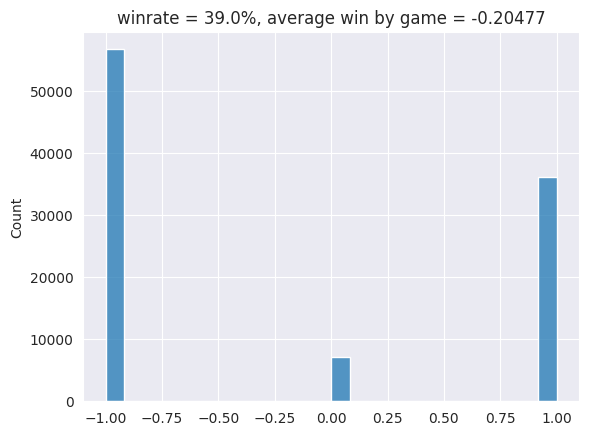

In [6]:
show_hist(me_first_time_at_casino(env))


# Часть 1. Пришел в казино после пары умных видео о том, как играть

In [7]:
logging_stamp = 100000
class Player:
    def __init__(self, num_dimensions, num_actions, eps=0.05):
        self.eps = eps
        self.actions = np.arange(num_actions)
        self.P = np.zeros(num_dimensions, dtype=int)

    def create_action(self, state):
        if type(state[0]) is tuple:
            state = state[0]
        if np.random.rand() <= self.eps:
            return np.random.choice(self.actions)
        return self.P[tuple(map(int, state))]

class MCControl:
    def __init__(self, env, num_dimensionals, num_actions, omega):
        self.reward_while_training = []
        self.env = env
        self.Q = np.zeros((*num_dimensionals, num_actions), dtype=float)
        self.player = Player(num_dimensionals, num_actions)
        self.omega = omega

    def calc_reward(self, num_plays=100000):
        rewards = []
        for i in range(num_plays):
            temp_state = self.env.reset()
            if type(temp_state[0]) is tuple:
                temp_state = temp_state[0]
            stop = False
            while not stop:
                action = self.player.create_action(temp_state)
                temp_state, reward, stop, kek1, kek2 = self.env.step(action)
            rewards.append(reward)
        return rewards

    def one_game(self):
        episod = []
        state = (env.reset(),)
        episod.append((-1, state))
        act = self.player.create_action(state[0])
        ans = self.env.step(act)
        episod.append((act, ans))
        while not ans[2]:
            act = self.player.create_action(ans[0])
            ans = env.step(act)
            episod.append((act, ans))
        return episod

    def fit(self, train_iterations=100000):
        rewards_by_iterations = []
        num_observations = np.copy(self.Q)
        for iter_idx in tqdm.tqdm_notebook(range(int(train_iterations))):
            gain = 0.
            rounds = self.one_game()
            for round_id in range(len(rounds)-1, 0, -1):
                round = rounds[round_id]
                action = round[0]
                temp_state = rounds[round_id-1][1][0]
                if type(temp_state[0]) is tuple:
                    temp_state = temp_state[0]
                temp_state = tuple(map(int, temp_state))
                temp_reward =round[1][1]
                num_observations[temp_state][action] += 1
                gain = self.omega * gain + temp_reward
                self.Q[temp_state][action] = self.Q[temp_state][action] + (gain - self.Q[temp_state][action]) / num_observations[temp_state][action]
                self.player.P[temp_state] = np.argmax(self.Q[temp_state])
            if iter_idx % logging_stamp == 0:
                self.player.eps*=0
                match_history = np.array(self.calc_reward())
                rewards_by_iterations.append(sum(match_history) / match_history.shape[0])
        return rewards_by_iterations

In [8]:
env = gym.make('Blackjack-v1')
dim = (32, 11, 2)
num_actions = 2
MCcontrol_onpolicy = MCControl(env, dim, num_actions, 0.95)

In [9]:
logs = MCcontrol_onpolicy.fit(train_iterations = 1000000)

/tmp/ipykernel_172012/1989633994.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iter_idx in tqdm.tqdm_notebook(range(int(train_iterations))):


  0%|          | 0/1000000 [00:00<?, ?it/s]

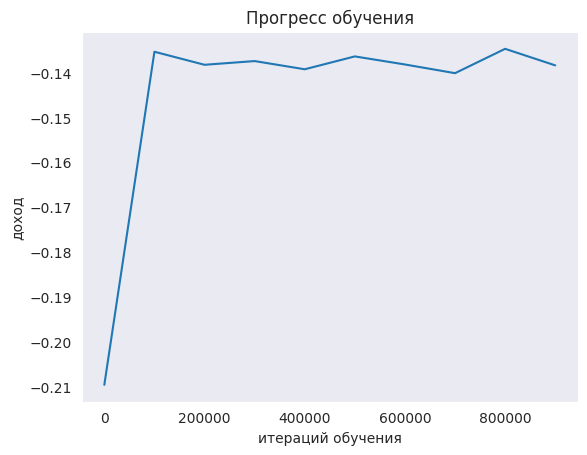

In [10]:
show_training([i * logging_stamp for i in range(len(logs))], logs)

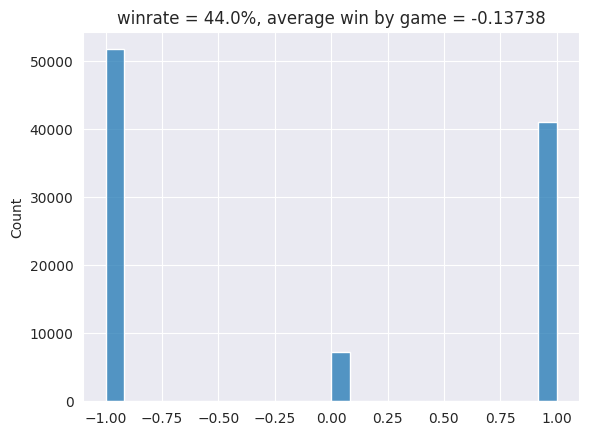

In [11]:
show_hist(MCcontrol_onpolicy.calc_reward())

# часть 2. Удвоение

In [12]:
%load_ext autoreload
%autoreload 2
from double import BlackjackEnv as Bj

In [13]:
env = Bj()
dim = (32, 11, 2)
num_actions = 3
MCcontrol_onpolicy_double = MCControl(env, dim, num_actions, 0.95)

In [14]:
logs_double = MCcontrol_onpolicy_double.fit(train_iterations = 3000000)

/tmp/ipykernel_92769/1989633994.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iter_idx in tqdm.tqdm_notebook(range(int(train_iterations))):


  0%|          | 0/3000000 [00:00<?, ?it/s]

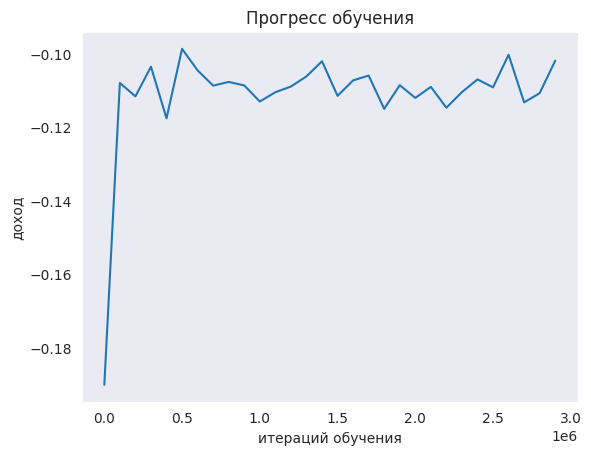

In [15]:
show_training([i * logging_stamp for i in range(len(logs_double))], logs_double)

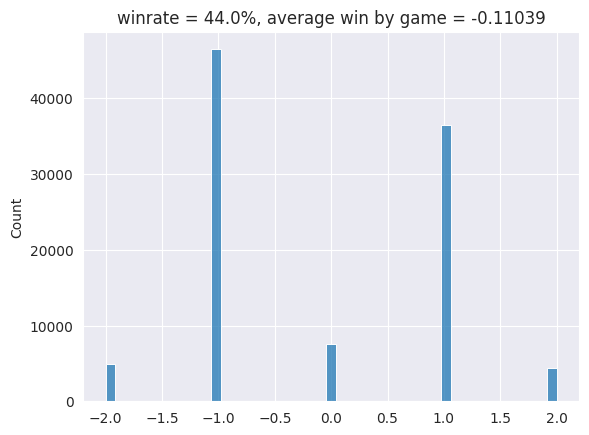

In [16]:
show_hist(MCcontrol_onpolicy_double.calc_reward())

# часть 3. Подсчет
![title](dvadcat-odno_0.jpg)



In [17]:
%load_ext autoreload
%autoreload 2
from count import BlackjackEnv as Bj_count

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
env = Bj_count()
dim = (32, 11, 2, 73)
num_actions = 3
MCcontrol_onpolicy_count = MCControl(env, dim, num_actions, 0.95)

In [19]:
logs_double_count = MCcontrol_onpolicy_count.fit(train_iterations = 3000000)

/tmp/ipykernel_13561/1989633994.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iter_idx in tqdm.tqdm_notebook(range(int(train_iterations))):


  0%|          | 0/3000000 [00:00<?, ?it/s]

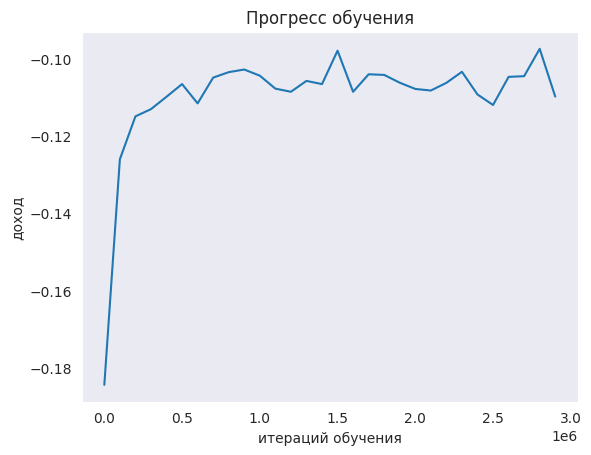

In [20]:
show_training([i * logging_stamp for i in range(len(logs_double_count))], logs_double_count)

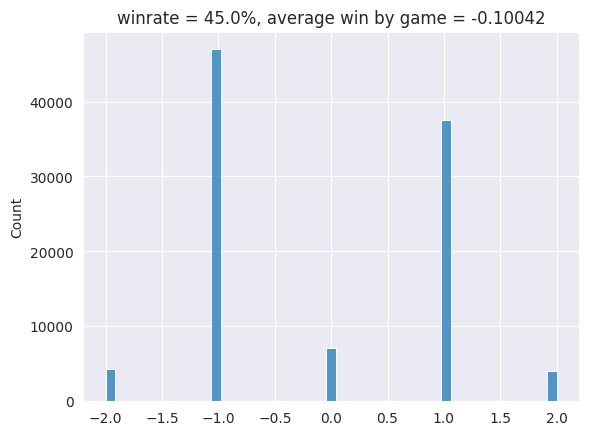

In [21]:
show_hist(MCcontrol_onpolicy_count.calc_reward())

# выводы

По итогу обыграть казино не удалось. Видимо, стоит использовать другие методы, Monte-carlo on policy control не справляется.
Переход от обычного env в gym к новому с удвоением и подсчетом дает улучшение результата, но не так сильно, как это ожидалось.
Во время выполнения домашки я выглядел как на картинке ниже.

![title](kek1.png)

Но в целом домашнее задание мне понравилось, было интересно.
До встречи в следующей домашке.


![title](Nikolenko_cat.jpg)
